In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [51]:
COLOR_0 = "#ef476f"
COLOR_1 = "#ffd166"


def gen_bound_squares_plus(depth):
    squares = []
    if depth == 0:
        return squares
    squares.append([np.array([[0, 0], [1, 1]])])
    for d in range(1, depth):
        squares_new = []
        for square in squares[d - 1]:
            squares_new += squares_in_square_plus(square)
        squares.append(squares_new)
    return [square for squares_d in squares for square in squares_d]


def squares_in_square_plus(square):
    w = square[1, 0] - square[0, 0]
    h = square[1, 1] - square[0, 1]
    assert w == h
    # top square
    top = np.array(
        [
            [square[0, 0] + w / 4, square[0, 1] + w / 2],
            [square[1, 0] - w / 4, square[1, 1]],
        ]
    )
    left = np.array(
        [
            square[0],
            [square[1, 0] - w / 2, square[1, 1] - w / 2],
        ]
    )
    right = np.array(
        [
            [square[0, 0] + w / 2, square[0, 1]],
            [square[1, 0], square[1, 1] - w / 2],
        ]
    )
    return top, right, left


def negate_square(square):
    w = square[1, 0] - square[0, 0]
    return np.array(
        [
            [square[0, 0] + w / 4, square[0, 1]],
            [square[1, 0] - w / 4, square[1, 1] - w / 2],
        ]
    )


def square_to_flipped_equil_triangle(square):
    w = square[1, 0] - square[0, 0]
    return np.array(
        [
            [square[0][0], square[1][1]],
            square[1],
            [square[0][0] + w / 2, square[0][1]],
        ]
    )


def gen_triangles(depth):
    bound_squares_plus = gen_bound_squares_plus(depth)
    triangles = []
    for square in bound_squares_plus:
        triangles.append(square_to_flipped_equil_triangle(negate_square(square)))
    return triangles


def sample_labeled_points(num_points, max_depth):
    def triangle_area(triangle):
        return 0.5 * abs(np.cross(triangle[1] - triangle[0], triangle[2] - triangle[0]))

    def generate_sierpinski_bounds(depth):
        triangles = [np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])]
        labels = [0]
        areas = [triangle_area(triangles[0])]

        for _ in range(depth):
            new_triangles = []
            new_labels = []
            new_areas = []
            for triangle, label in zip(triangles, labels):
                # Generate three new triangles
                midpoints = (triangle + np.roll(triangle, -1, axis=0)) / 2
                new_triangles.extend([
                    np.array([triangle[0], midpoints[0], midpoints[2]]),
                    np.array([midpoints[0], triangle[1], midpoints[1]]),
                    np.array([midpoints[2], midpoints[1], triangle[2]])
                ])
                new_labels.extend([1-label, 1-label, 1-label])
                for new_triangle in new_triangles[-3:]:
                    new_areas.append(triangle_area(new_triangle))
            
            triangles.extend(new_triangles)
            labels.extend(new_labels)
            areas.extend(new_areas)

        return np.array(triangles), np.array(labels), np.array(areas)

    def sample_point_from_triangle(triangle):
        r1, r2 = np.random.random(2)
        sqrt_r1 = np.sqrt(r1)
        return (1 - sqrt_r1) * triangle[0] + (sqrt_r1 * (1 - r2)) * triangle[1] + (r2 * sqrt_r1) * triangle[2]

    # Generate Sierpinski bounds
    triangles, labels, areas = generate_sierpinski_bounds(max_depth)

    # Normalize areas for probability distribution
    probs = areas / areas.sum()

    # Sample triangles based on their areas
    sampled_indices = np.random.choice(len(triangles), num_points, p=probs)

    # Generate points within the sampled triangles
    points = np.array([sample_point_from_triangle(triangles[i]) for i in sampled_indices])
    point_labels = labels[sampled_indices]

    return points, point_labels



def plot_triangles(triangles):
    fig, ax = plt.subplots(figsize=(6, 6))
    tri = plt.Polygon([[0, 0], [0.5, 1], [1, 0]], edgecolor="none", facecolor=COLOR_0)
    ax.add_patch(tri)
    for triangle in triangles:
        tri = plt.Polygon(triangle, edgecolor="none", facecolor=COLOR_1)
        ax.add_patch(tri)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()


/tmp/ipykernel_2049066/745982112.py:75: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return 0.5 * abs(np.cross(triangle[1] - triangle[0], triangle[2] - triangle[0]))


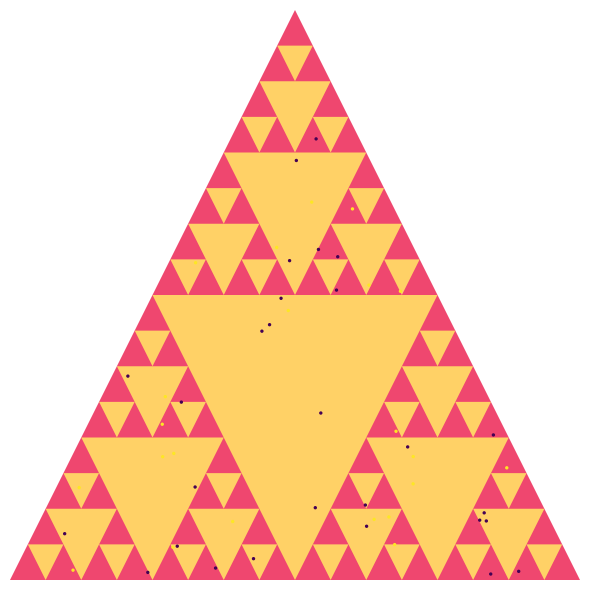

In [52]:
points, labels = sample_labeled_points(50, 2)
triangles = gen_triangles(4)
plot_triangles(triangles)
plt.scatter(points[:, 0], points[:, 1], c=labels, s=2)
